Customer Segmentation

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel(r"pathname")

In [44]:
df.head()

,saleid,customerid,productcategory,saledate,quantity,unitprice,paymenttype,employeeid
0,1,126,Books,2022-02-06,5,94.32,Online,74
1,2,132,Furniture,2022-04-07,2,59.95,Credit Card,42
2,3,99,Furniture,2022-01-09,1,343.07,Debit Card,27
3,4,456,Toys,2022-08-23,3,416.92,Online,81
4,5,443,Electronics,2022-04-20,2,485.40,Debit Card,31


In [45]:
df.dtypes

saleid                      int64
customerid                  int64
productcategory            object
saledate           datetime64[ns]
quantity                    int64
unitprice                 float64
paymenttype                object
employeeid                  int64
dtype: object

In [ ]:
#Recency for individual sale
now = '2024-01-14'
today = pd.to_datetime(now)

In [48]:
#OR

from datetime import datetime
today = datetime.now()
df['recency'] = (today - df['saledate']).dt.days

In [49]:
df.head()

,saleid,customerid,productcategory,saledate,quantity,unitprice,paymenttype,employeeid,recency
0,1,126,Books,2022-02-06,5,94.32,Online,74,1076
1,2,132,Furniture,2022-04-07,2,59.95,Credit Card,42,1016
2,3,99,Furniture,2022-01-09,1,343.07,Debit Card,27,1104
3,4,456,Toys,2022-08-23,3,416.92,Online,81,878
4,5,443,Electronics,2022-04-20,2,485.40,Debit Card,31,1003


In [50]:
recency = df.groupby('customerid')['recency'].max().reset_index() #Dont use reset_index()
recency

,customerid,recency
0,5,653
1,6,1188
2,12,572
3,13,5
4,14,1115
...,...,...
147,478,116
148,481,722
149,484,369
150,489,603


In [ ]:
#Recency for individual customer (aggregating sales per customer)
recency = df.groupby(['customerid']).agg({
    'saledate': lambda x: (today - x.max()).days
}).rename(columns={'saledate': 'recency'})
recency

,recency
customerid,
5,595
6,1188
12,572
13,5
14,1115
...,...
478,116
481,722
484,369


In [53]:
df.head()

,saleid,customerid,productcategory,saledate,quantity,unitprice,paymenttype,employeeid,recency
0,1,126,Books,2022-02-06,5,94.32,Online,74,1076
1,2,132,Furniture,2022-04-07,2,59.95,Credit Card,42,1016
2,3,99,Furniture,2022-01-09,1,343.07,Debit Card,27,1104
3,4,456,Toys,2022-08-23,3,416.92,Online,81,878
4,5,443,Electronics,2022-04-20,2,485.40,Debit Card,31,1003


In [ ]:
#Frequency
freq = df.drop_duplicates(subset='saleid').groupby(['customerid'])[['saleid']].count()
freq

,saleid
customerid,
5,2
6,1
12,1
13,1
14,1
...,...
478,1
481,1
484,1


In [ ]:
#Monetory
df["total"] = df['quantity']*df['unitprice']

In [58]:
money = df.groupby(['customerid'])[['total']].sum()
money

,total
customerid,
5,2226.96
6,1226.46
12,1874.16
13,834.64
14,899.80
...,...
478,1279.74
481,1320.70
484,1638.08


In [60]:
RFM  = pd.concat([recency,freq,money],axis=1)
recency.columns=["Recency"]
freq.columns =["Frequency"]
money.columns = ["Monetory"]
RFM

,Recency,Frequency,Monetory
customerid,,,
5,595,2,2226.96
6,1188,1,1226.46
12,572,1,1874.16
13,5,1,834.64
14,1115,1,899.80
...,...,...,...
478,116,1,1279.74
481,722,1,1320.70
484,369,1,1638.08


Cluster Analysis

In [ ]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(RFM)

In [ ]:
#Find No of clusters
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

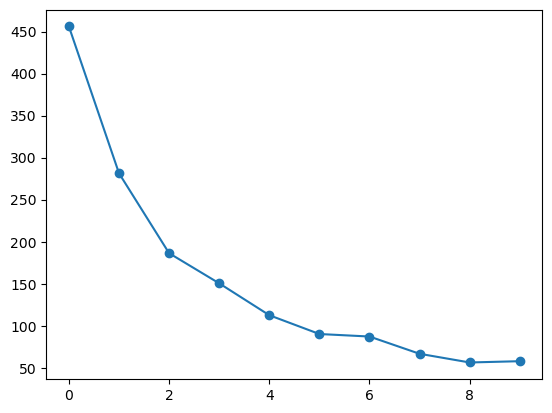

In [ ]:
inertia = []
for i in np.arange(1,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(inertia, marker="o");

In [ ]:
#Label the data points
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled)
RFM["Clusters"] = (kmeans.labels_+1)
RFM

,Recency,Frequency,Monetory,Clusters
customerid,,,,
5,595,2,2226.96,2
6,1188,1,1226.46,1
12,572,1,1874.16,3
13,5,1,834.64,3
14,1115,1,899.80,1
...,...,...,...,...
478,116,1,1279.74,3
481,722,1,1320.70,1
484,369,1,1638.08,3


In [ ]:
#Analyze the clusters
group= RFM.groupby(["Clusters"])[["Recency", "Frequency", "Monetory"]].mean()
group

,Recency,Frequency,Monetory
Clusters,,,
1,1037.000000,1.00,750.783676
2,467.800000,2.08,1520.139600
3,315.033898,1.00,798.815932


In [87]:
def func(row):
    if row["Clusters"] ==3:
        return 'Avg.Cust'
    elif row["Clusters"] ==2:
        return 'Whales'
    else:
        return 'Lapsed Cust'

In [88]:
RFM['Status'] = RFM.apply(func,axis=1)
RFM

,Recency,Frequency,Monetory,Clusters,Conditions,Status
customerid,,,,,,
5,595,2,2226.96,2,Whales,Whales
6,1188,1,1226.46,1,Avg.Cust,Lapsed Cust
12,572,1,1874.16,3,Lapsed Cust,Avg.Cust
13,5,1,834.64,3,Lapsed Cust,Avg.Cust
14,1115,1,899.80,1,Avg.Cust,Lapsed Cust
...,...,...,...,...,...,...
478,116,1,1279.74,3,Lapsed Cust,Avg.Cust
481,722,1,1320.70,1,Avg.Cust,Lapsed Cust
484,369,1,1638.08,3,Lapsed Cust,Avg.Cust


In [89]:
result = RFM["Status"].value_counts()
result

Status
Lapsed Cust    68
Avg.Cust       59
Whales         25
Name: count, dtype: int64

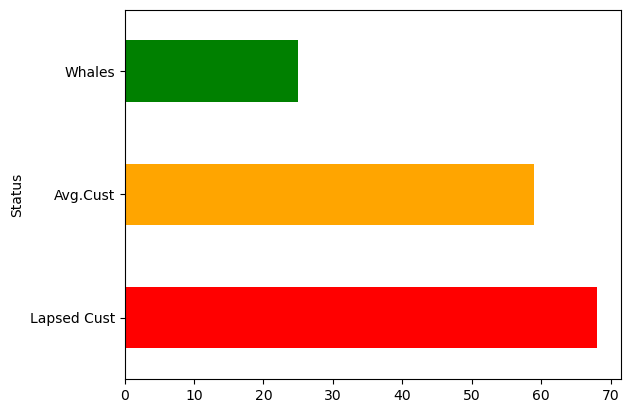

In [91]:
result.plot(kind='barh', color=["red","orange", "green"]);